# Setup Notebook

In [ ]:
# import standard libraries
import sys, os
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, ConcatDataset

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}")

Using device cuda


In [ ]:
# install weight and biases library
!pip install wandb > /dev/null
import wandb

In [ ]:
# setup repo
if os.path.exists('./dl-computer-vision'):
    !rm -r dl-computer-vision > /dev/null
!git clone https://github.com/simonamtoft/dl-computer-vision.git > /dev/null
sys.path.append('dl-computer-vision')

# import helpers as h
from data import LIDC_CLDV
from testing import test_pass_medical
from models import UNet
from training import train_medical

Cloning into 'dl-computer-vision'...
remote: Enumerating objects: 846, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 846 (delta 56), reused 67 (delta 33), pack-reused 753
Receiving objects: 100% (846/846), 21.12 MiB | 37.22 MiB/s, done.
Resolving deltas: 100% (539/539), done.


In [ ]:
# Define name of project on weight and biases site
project_name = "project-2"

In [ ]:
# Download data
import gdown
if not os.path.exists('./LIDC_crops/LIDC_DLCV_version'):
    url = 'https://drive.google.com/uc?id=1W6zB9UH4j_iHxaUcYZSdiEkzcJN77lSA'
    gdown.download(url, './LIDC.zip', quiet=True)
    !unzip ./LIDC.zip > /dev/null

# define path to data in your drive
path_to_data = "/content/LIDC_crops/LIDC_DLCV_version/"

# Project 2

In [ ]:
# login to weight and biases
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
config = {
    'epochs': 15,
    'batch_size': 64,
    'learning_rate': 1e-3, 
    'optimizer': 'adam',
    'loss_func': ['bce_weight', [25]],
    'batch_norm': True,
    'dropout': 0.2,
    'channels': [64, 128, 256],
    'n_convs': 3,
    'step_lr': [False, 1, 0.8],
    'padding': 1
}

## Get Data

In [ ]:
# Define data transforms UNUSED ATM
transform = transforms.Compose([])
common_transform = transforms.Compose([])

# Define annotator (-1 is all 4)
annotator = -1

# Chose whether to affine the training data or not
affine = False

In [ ]:
# Get data from files
trainset = LIDC_CLDV(
    split='train', 
    affine=affine,
    data_path=path_to_data,
    annotator=annotator, 
    transform=transform, 
    common_transform=common_transform
)
valset = LIDC_CLDV(
    split='val', 
    data_path=path_to_data,
    annotator=annotator, 
    transform=transform, 
    common_transform=common_transform
)
testset = LIDC_CLDV(
    split='test',
    data_path=path_to_data,
    annotator=annotator, 
    transform=transform, 
    common_transform=common_transform
)

# Setup data loaders
train_loader = DataLoader(
    trainset, batch_size=config['batch_size'], shuffle=True, num_workers=2)
val_loader = DataLoader(
    valset, batch_size=config['batch_size'], shuffle=True, num_workers=2)
test_loader = DataLoader(
    testset, batch_size=config['batch_size'], shuffle=False, num_workers=2)

In [ ]:
# X, y = next(iter(train_loader))

In [ ]:
# Display a single image with 4 annotators
# f, ax = plt.subplots(1, 5, figsize=(12, 10))
# idx = 21 # 4, 9, 14, 18, 20
# ax[0].imshow(X[idx][0], cmap='gray')
# ax[0].set_title('Image')
# ax[0].axis('off')
# for i in range(1, 5):
#     ax[i].imshow(y[idx, i-1, 0], cmap='gray')
#     ax[i].axis('off')
#     ax[i].set_title(f'Annotation {i}')
# f.tight_layout()
# f.savefig('data.png', dpi=300, transparent=True, bbox_inches='tight')

In [ ]:
# Display multiple images with annotators
# f, ax = plt.subplots(1 + y.shape[1], 5, figsize=(12, 10))
# for i in range(5):
#     ax[0, i].imshow(X[i, 0].numpy(), cmap='gray')
#     ax[0, i].axis('off')
#     for j in range(y.shape[1]):
#         ax[1+j, i].imshow(y[i, j, 0].numpy(), cmap='gray')
#         ax[1+j, i].axis('off')

## Train Model

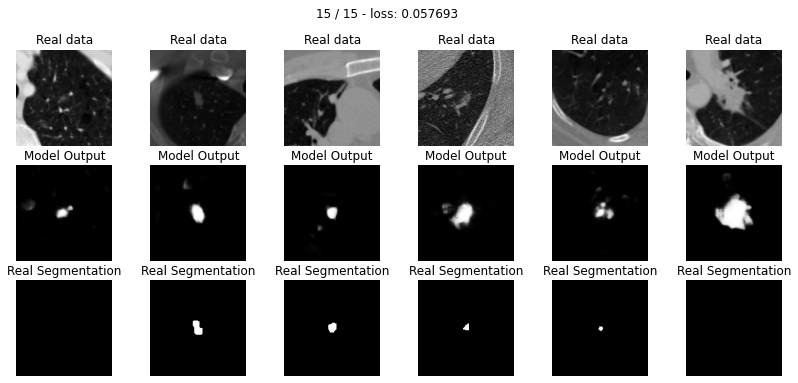

train_loss,0.04198
valid_loss,0.05769
train_dice,0.37523
train_iou,0.28563
train_acc,0.99066
train_sens,0.60844
train_spec,0.9908
val_dice,0.35472
val_iou,0.27469
val_acc,0.99188
val_sens,0.54948


train_loss,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁
valid_loss,█▄▂▃▁▂▂▃▃▁▁▁▁▁▁
train_dice,▁▄▅▆▆▇▇▇▇▇▇▇███
train_iou,▁▄▅▆▆▆▇▇▇▇▇▇███
train_acc,▁▅▆▇▇▇▇▇▇██████
train_sens,▁▆▇▇▇██████████
train_spec,▁▄▆▆▇▇▇▇▇██████
val_dice,▁▄▆▆▆▄▇▃▅▆▇██▇█
val_iou,▁▄▅▆▅▄▇▃▅▅▇██▇█
val_acc,██▆█▆▅█▁▇▆▇█▇▇▇
val_sens,▁▃▇▅▇█▆█▄█▇▇▇█▇


In [ ]:
# instantiate the model
model = UNet(config).to(device)

# train the model
train_dict, val_dict = train_medical(model, config, train_loader, val_loader, project_name)

## Evaluate on test set

In [ ]:
test_dict = test_pass_medical(config, model, test_loader)

## Show resulting metrics

In [ ]:
print("\tdice \tiou \tacc \tsens \tspec")
# print(train_dict['metrics'])
print(val_dict['metrics'])
# print(test_dict['metrics'])

	dice 	iou 	acc 	sens 	spec
tensor([0.3547, 0.2747, 0.9919, 0.5495, 0.9923], dtype=torch.float64)


Bar plot of performance metrics for different class weights

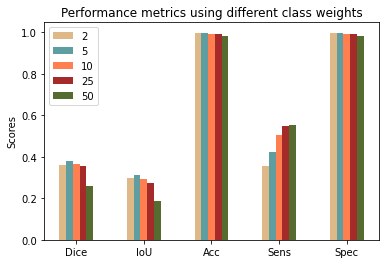

In [ ]:
# weight_1 = []
weight_2 = [0.3611, 0.3, 0.9967, 0.3566, 0.9984]
weight_5 = [0.3786, 0.3137, 0.9957, 0.4251, 0.9968]
weight_10 = [0.3662, 0.2926, 0.9933, 0.5066, 0.9940]
weight_25 = [0.3547, 0.2747, 0.9919, 0.5495, 0.992]
weight_50 = [0.2611, 0.1870, 0.9841, 0.5518, 0.9843] 

# dice = [0.3611, 0.3786, 0.3662, 0.2611]
# iou = [0.3, 0.3137, 0.2926, 0.1870]
# acc = [0.9967, 0.9957, 0.9933, 0.9841]
# sens = [0.3566, 0.4251, 0.5066, 0.5518]
# spec = [0.9984, 0.9968, 0.9940, 0.9843]

# x = [2, 5, 10, 50]

ind = np.arange(5)
width = 0.1

fig = plt.figure()
ax = fig.add_subplot(111)


rects_2 = ax.bar(ind-width, weight_2, width, color='burlywood')
rects_5 = ax.bar(ind, weight_5, width, color='cadetblue')
rects_10 = ax.bar(ind+width, weight_10, width, color='coral')
rects_25 = ax.bar(ind+2*width, weight_25, width, color='brown')
rects_50 = ax.bar(ind+3*width, weight_50, width, color='darkolivegreen')


ax.set_ylabel('Scores')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('Dice', 'IoU', 'Acc', 'Sens', 'Spec') )
ax.legend( (rects_2[0], rects_5[0], rects_10[0], rects_25[0], rects_50[0]), ('2', '5', '10', '25', '50') )
ax.set_title('Performance metrics using different class weights')
fig.savefig('weights_bar.png', dpi=300, transparent=True, bbox_inches='tight')